In [1]:
# activate .venv
# make sure to use pandas 1.5.0 (pip3 install pandas==1.5.0)
# need rpy2 (pip3 install rpy2)
# import packages and data
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank
import cellrank as cr
import scanpy as sc

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

import warnings

warnings.simplefilter("ignore", category=UserWarning)

# load data
adata = cr.datasets.bone_marrow()
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

In [2]:
# Move MAGIC imputed data to layers
adata = adata[:, adata.var["palantir"]].copy()
adata.layers["MAGIC_imputed_data"] = adata.obsm["MAGIC_imputed_data"].copy()

In [3]:
# Preprocess data
# filter and normalize
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

In [4]:
# compute PCA and k-NN graph
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, random_state=0)

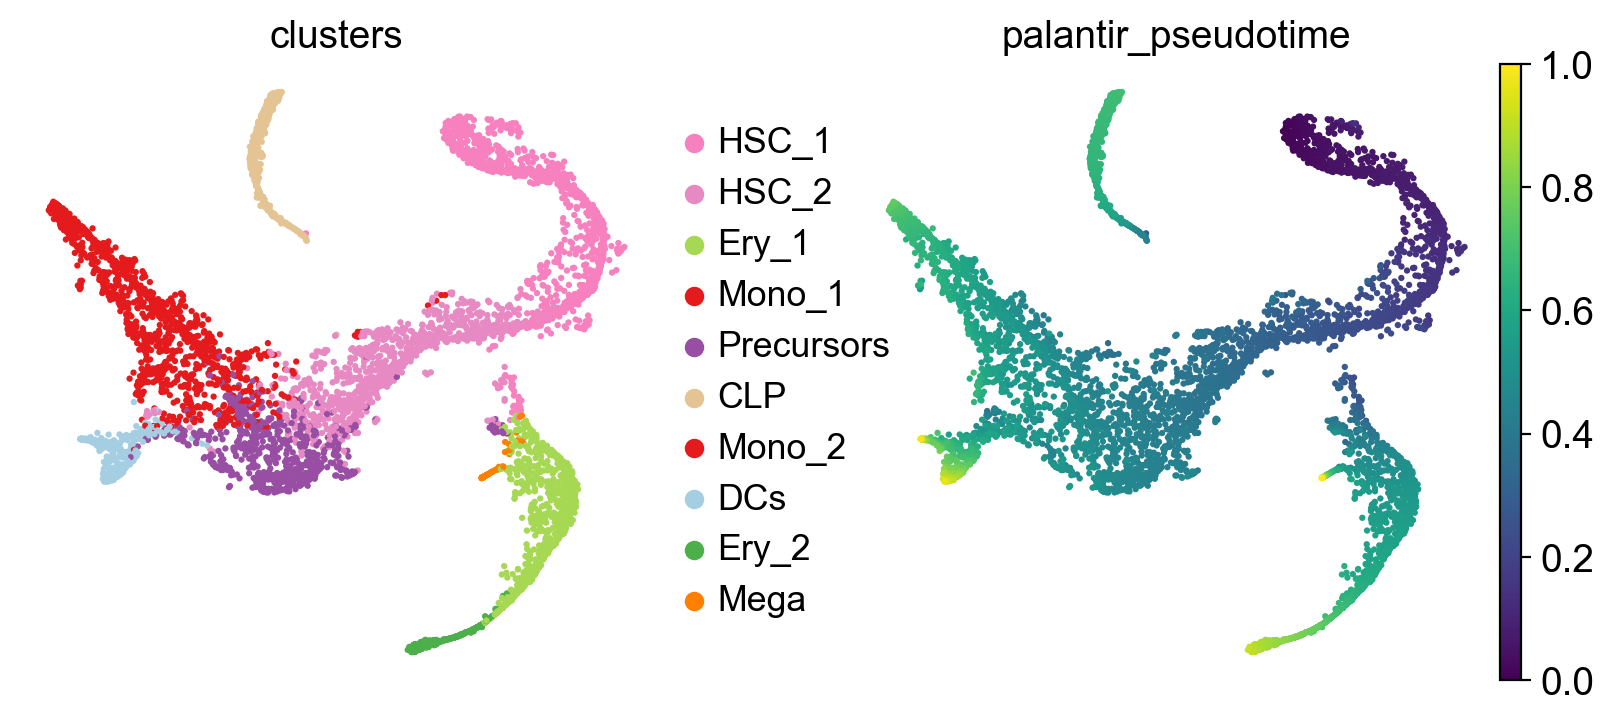

In [5]:
# Visualize this data, using the t-SNE embedding, cluster labels and Palantir pseudotime
sc.pl.embedding(adata, basis="tsne", color=["clusters", "palantir_pseudotime"])

In [6]:
# set up a kernel
# the PseudotimeKernel which biases k-NN graph edges to point into the direction of increasing pseudotime
from cellrank.kernels import PseudotimeKernel

pk = PseudotimeKernel(adata, time_key="palantir_pseudotime") # note uses palantir time

In [7]:
pk

PseudotimeKernel[n=5780]

In [8]:
# use this kernel to compute a cell-cell transition_matrix
pk.compute_transition_matrix()

Computing transition matrix based on pseudotime


100%|██████████| 5780/5780 [00:00<00:00, 11812.48cell/s]


    Finish (0:00:00)


PseudotimeKernel[n=5780, dnorm=False, scheme='hard', frac_to_keep=0.3]

In [9]:
pk

PseudotimeKernel[n=5780, dnorm=False, scheme='hard', frac_to_keep=0.3]

Simulating `100` random walks of maximum length `1445`


100%|██████████| 100/100 [00:10<00:00,  9.87sim/s]

    Finish (0:00:10)
Plotting random walks


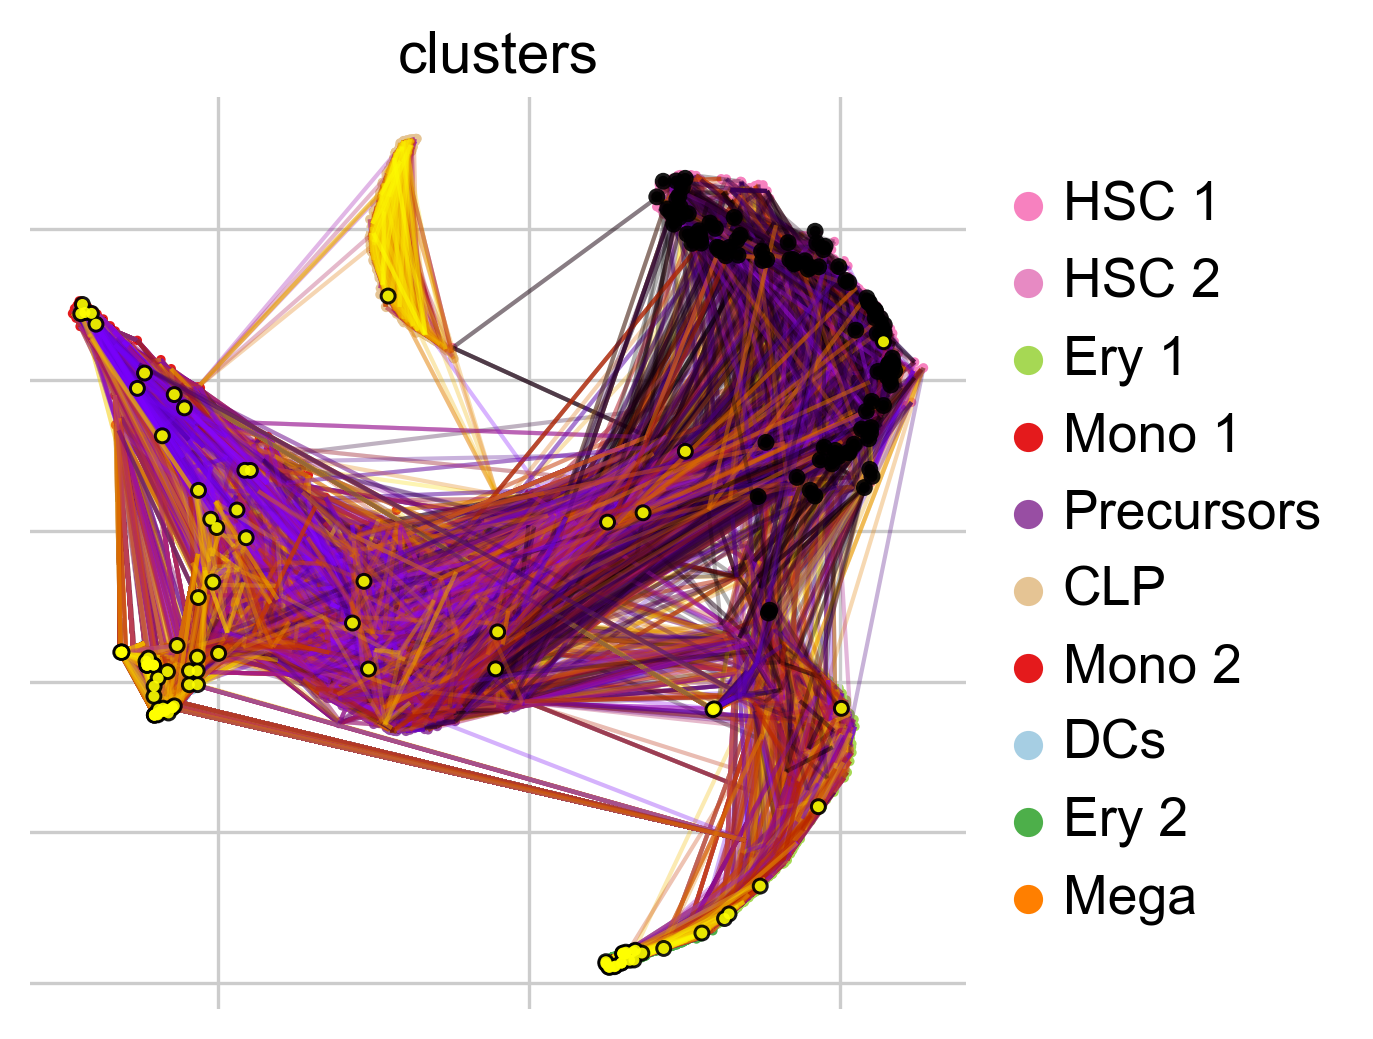

In [10]:
# To get a first impression of the cellular dynamics in this dataset, we can simulate random walks on the Markov chain implied by the transition matrix, 
# starting from hematopoietic stem cells (HSCs). Visualize with tsne.
pk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={"clusters": "HSC_1"},
    basis="tsne",
    legend_loc="right",
    dpi=150,
)


In [11]:
# Combining different kernels
# Any two kernels can be globally combined via a weighted mean. To demonstrate this, let’s set up an additional cellrank.kernels.ConnectivityKernel, 
# based on gene expression similarity.
from cellrank.kernels import ConnectivityKernel

ck = ConnectivityKernel(adata).compute_transition_matrix()

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


In [12]:
ck

ConnectivityKernel[n=5780, dnorm=True, key='connectivities']

In [13]:
# Combine with the PseudotimeKernel from above.
combined_kernel = 0.8 * pk + 0.2 * ck
combined_kernel

(0.8 * PseudotimeKernel[n=5780, dnorm=False, scheme='hard', frac_to_keep=0.3] + 0.2 * ConnectivityKernel[n=5780, dnorm=True, key='connectivities'])

Projecting transition matrix onto `tsne`
Adding `adata.obsm['T_fwd_tsne']`
    Finish (0:00:00)


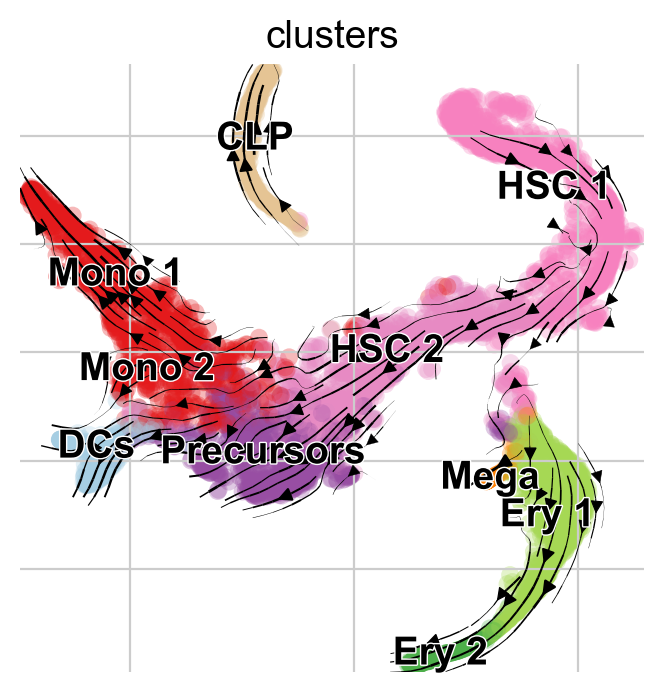

In [14]:
# plot combined kernel tsne
combined_kernel.plot_projection(basis="tsne", recompute=True)

In [15]:
# reading and writing the kernel
pk.write_to_adata()
adata.write("hematopoiesis.h5ad")

In [16]:
# read back in and initialize pseudotime kernel
adata = sc.read("hematopoiesis.h5ad")
pk_new = cr.kernels.PseudotimeKernel.from_adata(adata, key="T_fwd")
pk_new

PseudotimeKernel[n=5780, dnorm=False, frac_to_keep=0.3, scheme='hard']

In [17]:
# Working with estimators
# Estimators take a kernel object and offer methods to analyze it. The main objective is to decompose the state space into a set of macrostates that 
# represent the slow-time scale dynamics of the process.
# A subset of these macrostates will be the initial or terminal states of the process, the remaining states will be intermediate transient states.
# cellrank.estimators:
# CFLARE: Clustering and Filtering Left And Right Eigenvectors. Heuristic method based on the spectrum of the transition matrix.
# GPCCA: Generalized Perron Cluster Cluster Analysis: project the Markov chain onto a small set of macrostates using a Galerkin projection which 
# maximizes the self-transition probability for the macrostates.
from cellrank.estimators import GPCCA

g = GPCCA(pk_new)
print(g)

GPCCA[kernel=PseudotimeKernel[n=5780], initial_states=None, terminal_states=None]


Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:01:13)
Computing `10` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:07)


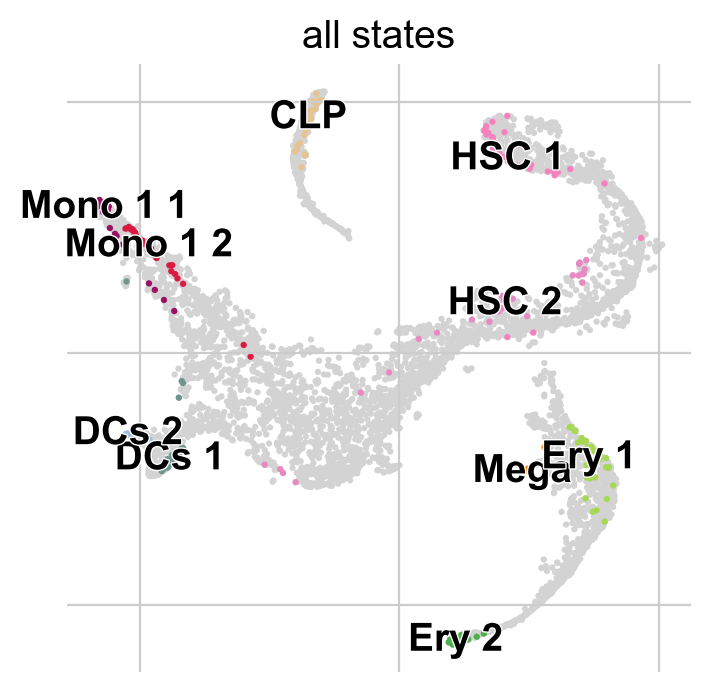

In [18]:
# Identify initial and terminal states
g.fit(n_states=10, cluster_key="clusters")
g.plot_macrostates(which="all")

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


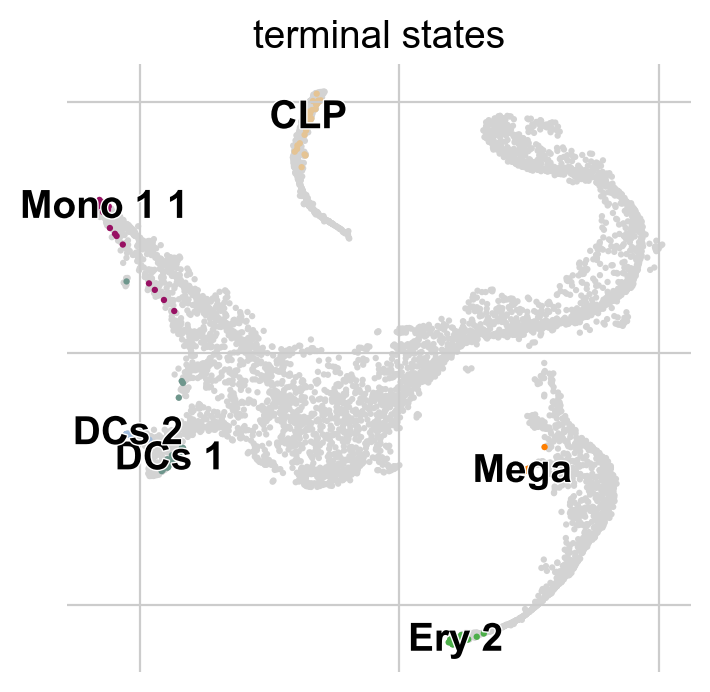

In [19]:
# For each macrostate, the algorithm computes an associated stability value. Let’s use the most stable macrostates as terminal states.
g.predict_terminal_states(method="top_n", n_states=6)
g.plot_macrostates(which="terminal")

Computing fate probabilities
Defaulting to `'gmres'` solver.


100%|██████████| 6/6 [00:00<00:00, 41.27/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


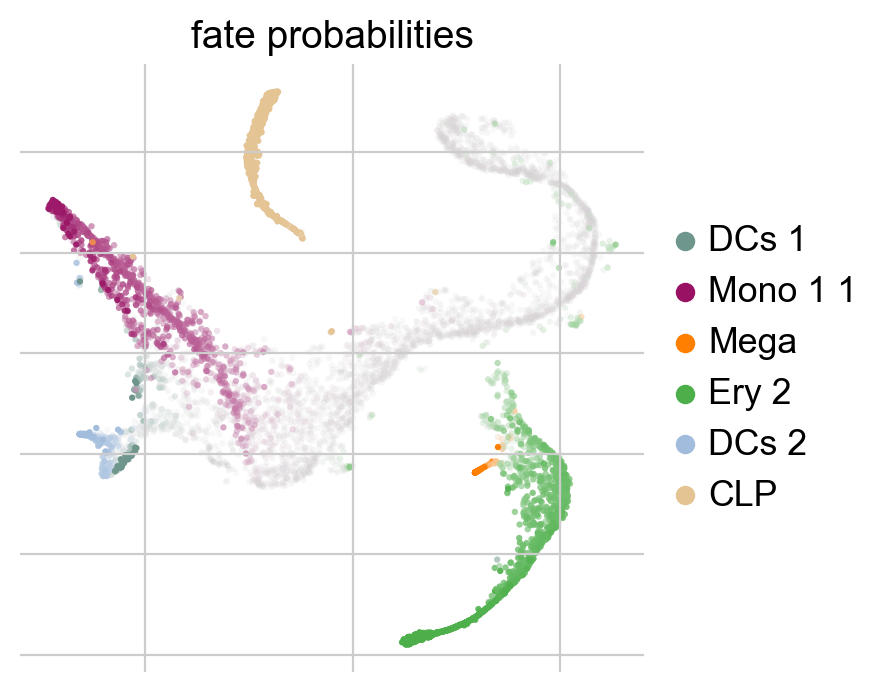

In [20]:
# Compute fate probabilities and driver genes
g.compute_fate_probabilities()
g.plot_fate_probabilities(legend_loc="right")

Solving TSP for `6` states


/Users/bmoore/Desktop/scRNAseq/.venv/lib/python3.11/site-packages/pandas/core/algorithms.py:514: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


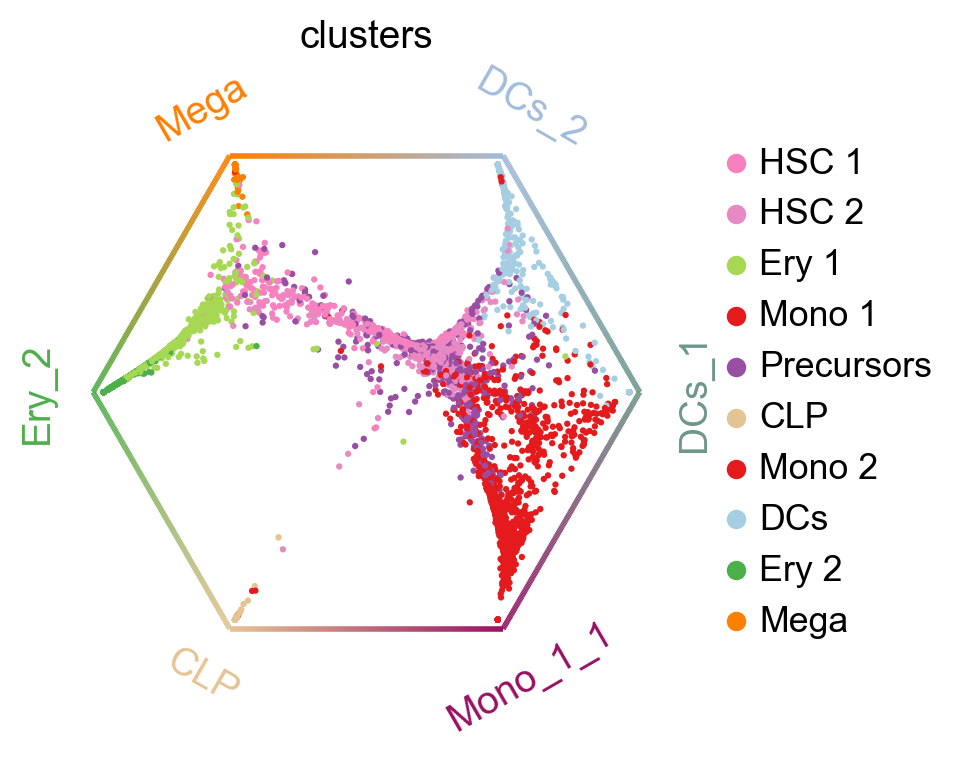

In [21]:
# circular plot
cr.pl.circular_projection(adata, keys="clusters", legend_loc="right")

In [22]:
# To infer putative driver genes for any of these trajectories, we correlate expression values with fate probabilities.
mono_drivers = g.compute_lineage_drivers(lineages="Mono_1_1")
mono_drivers.head(10)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


,Mono_1_1_corr,Mono_1_1_pval,Mono_1_1_qval,Mono_1_1_ci_low,Mono_1_1_ci_high
index,,,,,
AZU1,0.774124,0.0,0.0,0.763582,0.784253
MPO,0.741922,0.0,0.0,0.730106,0.753294
ELANE,0.736212,0.0,0.0,0.724176,0.747800
CTSG,0.721920,0.0,0.0,0.709341,0.734039
PRTN3,0.721313,0.0,0.0,0.708711,0.733455
CFD,0.614426,0.0,0.0,0.598120,0.630224
RNASE2,0.595178,0.0,0.0,0.578270,0.611575
MS4A3,0.581164,0.0,0.0,0.563830,0.597985
SRGN,0.570439,0.0,0.0,0.552787,0.587579


In [24]:
# Expression trends
# Given fate probabilities and a pseudotime, we can plot trajectory-specific gene expression trends.
# fit Generalized Additive Models (GAMs), weighthing each cells contribution to each trajectory according to its vector of fate probabilities.
model = cr.models.GAMR(adata)

Computing trends using `1` core(s)


100%|██████████| 4/4 [00:00<00:00,  4.61gene/s]

    Finish (0:00:00)
Plotting trends


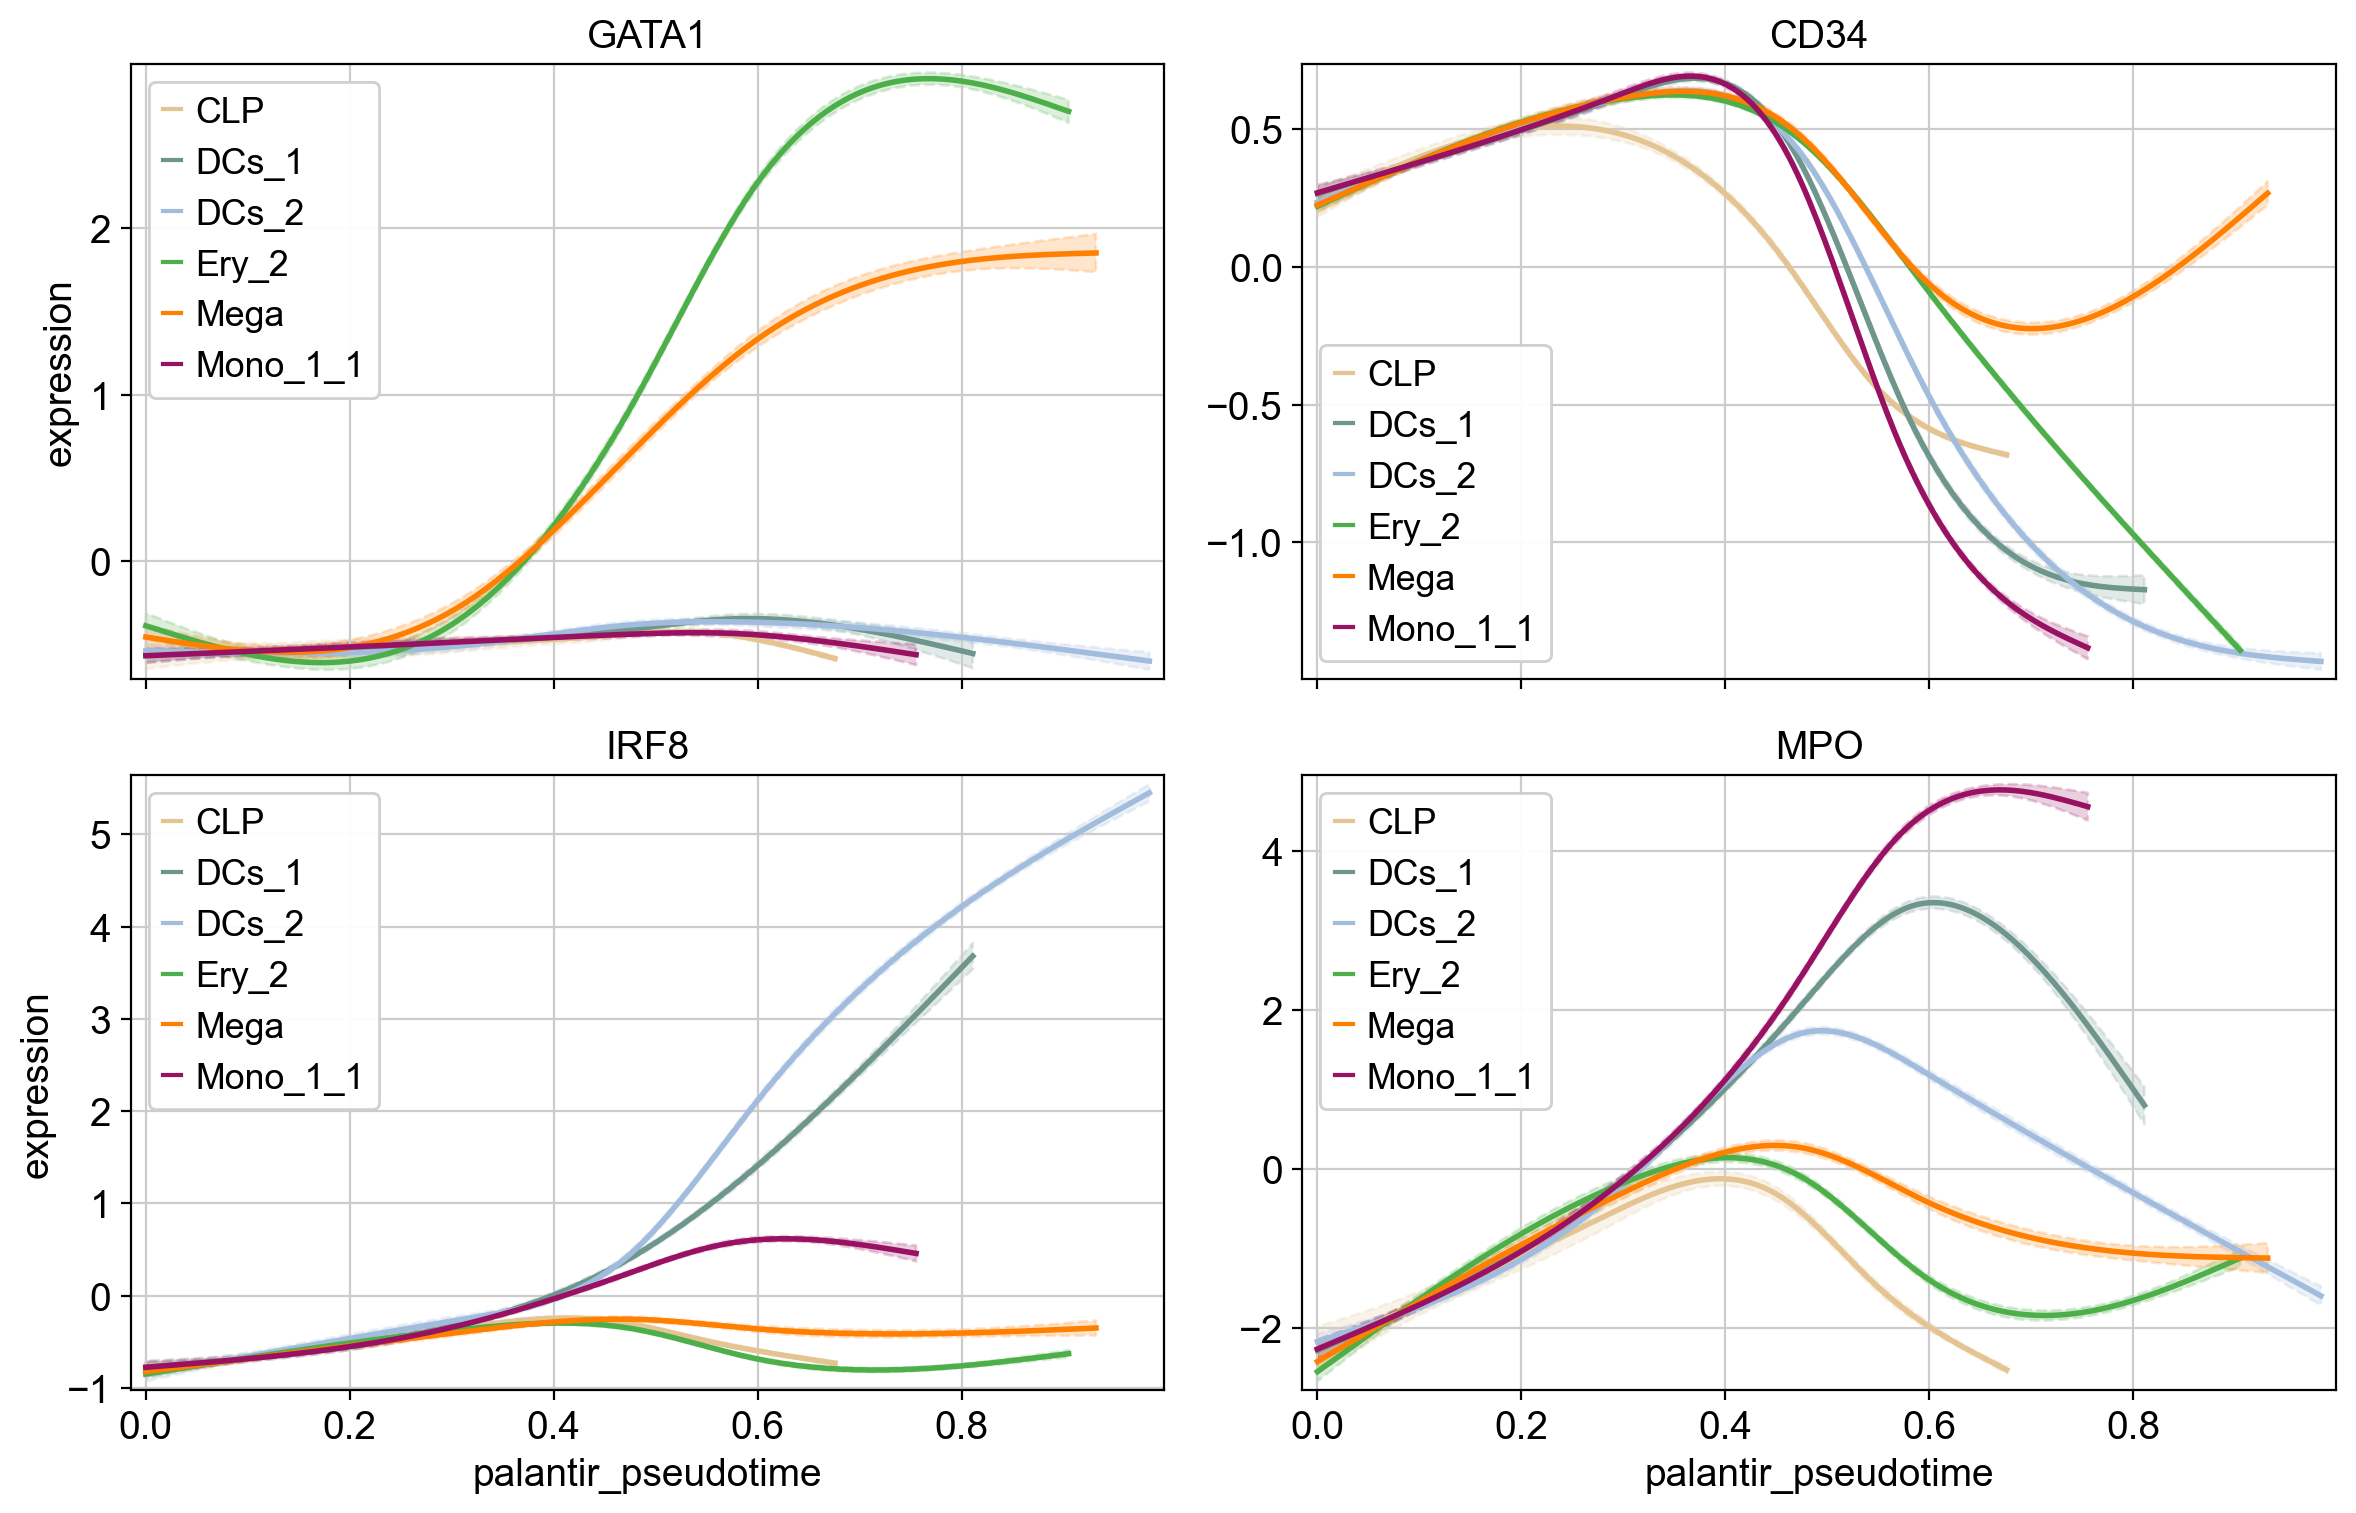

In [25]:
# visualize expression trends
cr.pl.gene_trends(
    adata,
    model=model,
    data_key="MAGIC_imputed_data",
    genes=["GATA1", "CD34", "IRF8", "MPO"],
    same_plot=True,
    ncols=2,
    time_key="palantir_pseudotime",
    hide_cells=True,
)

Computing trends using `1` core(s)


100%|██████████| 4/4 [00:00<00:00,  7.42gene/s]

    Finish (0:00:00)


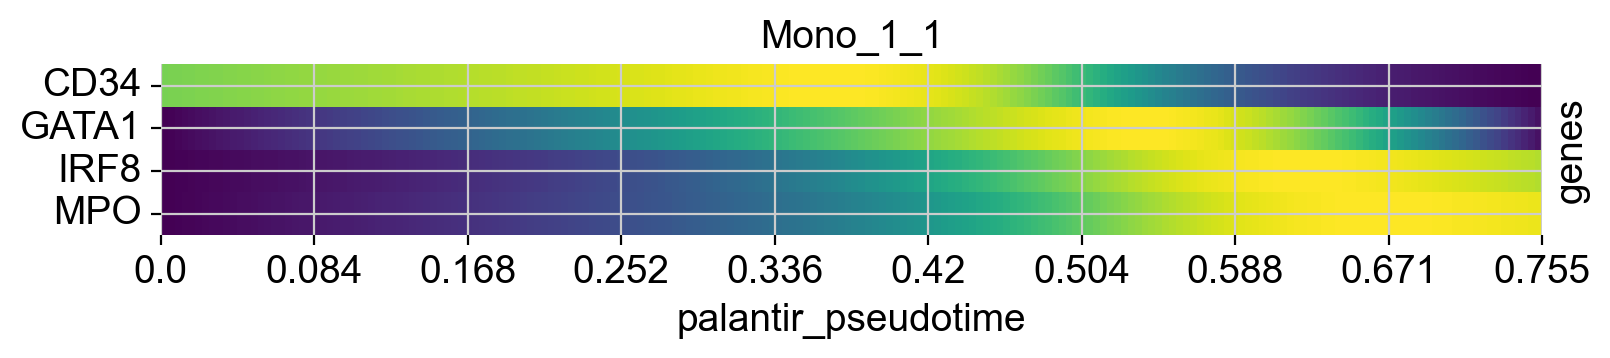

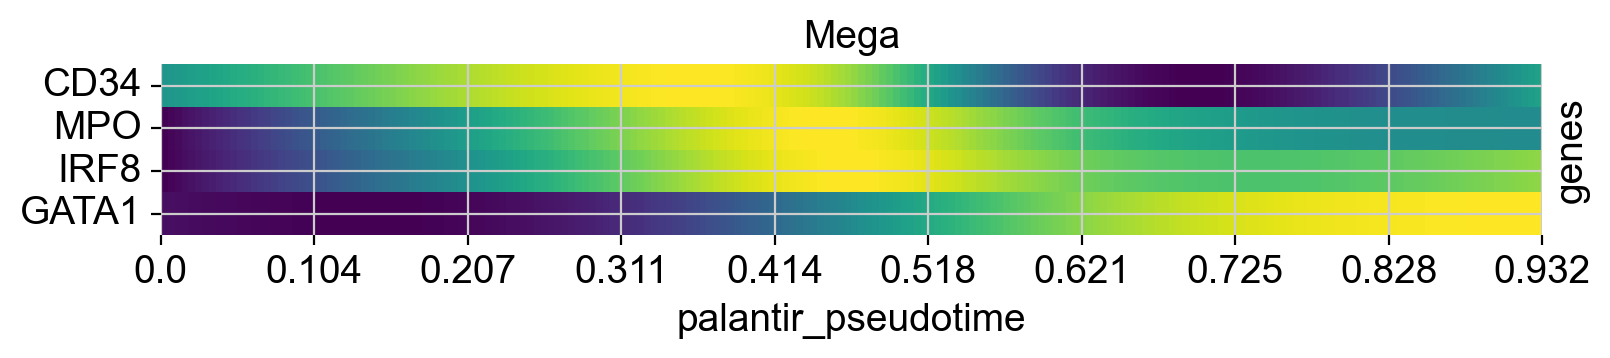

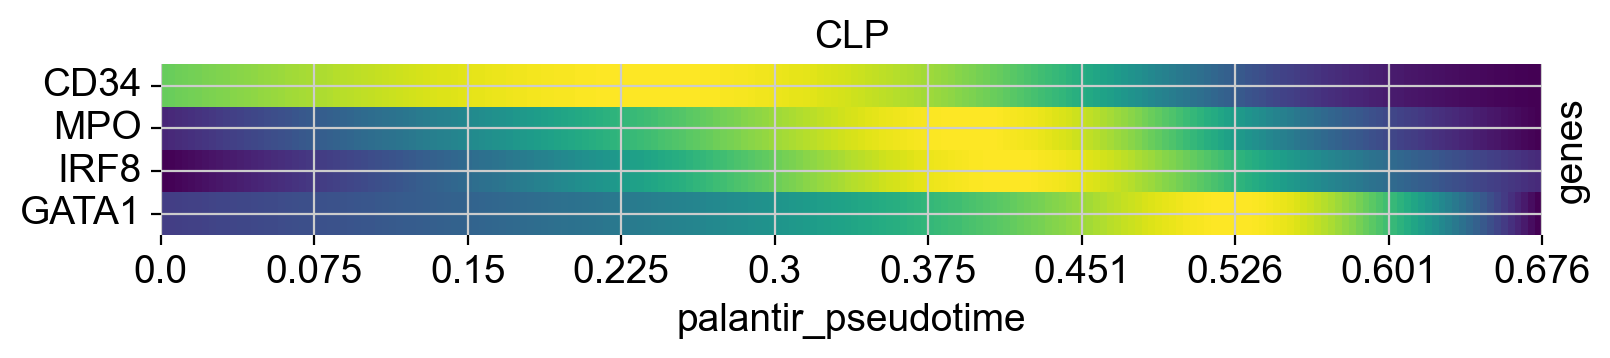

In [26]:
# Visulaize group expression trends by trajectory, visualize several genes per panel.
cr.pl.heatmap(
    adata,
    model=model,
    data_key="MAGIC_imputed_data",
    genes=["GATA1", "CD34", "IRF8", "MPO"],
    lineages=["Mono_1_1", "Mega", "CLP"],
    time_key="palantir_pseudotime",
    cbar=False,
    show_all_genes=True,
)

In [27]:
# package versions
cr.logging.print_versions()

cellrank==2.0.0 scanpy==1.9.5 anndata==0.10.2 numpy==1.25.2 numba==0.58.0 scipy==1.11.3 pandas==1.5.0 pygpcca==1.0.4 scikit-learn==1.3.1 statsmodels==0.14.0 python-igraph==0.10.8 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.7.1 seaborn==0.13.0
